# Lesson 1 - Own Image dataset



The goal of this assignment is to create my own image dataset and use ResNet to classify the images

**Idea: Classify paintings from: Van Gogh, Picasso, Monet, Dali**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from fastai import *
from fastai.vision import *
import warnings

## Get images from Google Images: 
https://forums.fast.ai/t/tips-for-building-large-image-datasets/26688
I ran into some errors, especially to install both Chrome and Chromedriver from the command line.
What worked:
1. ``pip install google_images_download``
2. go to: https://chromedriver.storage.googleapis.com/index.html?path=73.0.3683.20/
3. Download chromedriver_linux64.zip , unzip it and add the chromedriver binary file to: /usr/local/bin
4. Install chrome following this thread: https://askubuntu.com/questions/79280/how-to-install-chrome-browser-properly-via-command-line (first or second answer)
5. Finally, run: ``googleimagesdownload -k "monet paintings" -s medium -f jpg  -l 300 -o train/ -i monet  -cd /usr/local/bin/chromedriver``

## Train and validation sets
* Train: 300 images ``path_img/train``
* Validation: 200 images ``path_img/valid``

Code: ``googleimagesdownload -k "monet paintings" -s medium -f jpg  -l 400 -o valid/ -i monet  -cd /usr/local/bin/chromedriver -of 300``

## Looking at the data

In [3]:
path = Path("/home/jupyter/assignments")
path_img = path/'lesson1/art'
path.ls()

[PosixPath('/home/jupyter/assignments/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/assignments/lesson1')]

Some of our images are corrupted, so we found this script that removes them.


In [5]:

def check_images(path_img):   
    broken_images=[]
    for pic_class in os.listdir(path_img):
        for pic in os.listdir(f'{path_img}/{pic_class}'):
            try:
                img = PIL.Image.open(f'{path_img}/{pic_class}/{pic}') 
                img.verify()
            except (IOError, SyntaxError) as e:
                print('Bad file:', f'{path_img}/{pic_class}/{pic}')
                broken_images.append(f'{path_img}/{pic_class}/{pic}')
    return broken_images
# Train
img_to_del = check_images(f'{path_img}/train')
[os.remove(pic) for pic in img_to_del]

# Validation
img_to_del = check_images(f'{path_img}/valid')
[os.remove(pic) for pic in img_to_del]

[]

In [7]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path_img, ds_tfms=tfms, size=224)

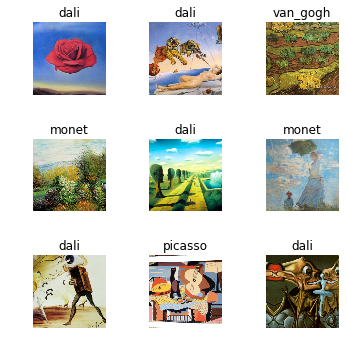

In [8]:
data.show_batch(rows=3, figsize=(5,5))

In [9]:
print(data.classes)

['dali', 'monet', 'picasso', 'van_gogh']


In [10]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [14]:
warnings.simplefilter('ignore', PIL.Image.DecompressionBombWarning)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.360464,0.375245,0.129921
2,0.353978,0.402890,0.132546
3,0.344992,0.388095,0.133858
4,0.304991,0.379705,0.128609


## Results
Let's interpret the results:

* "Categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. "

* Confusion matrix

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

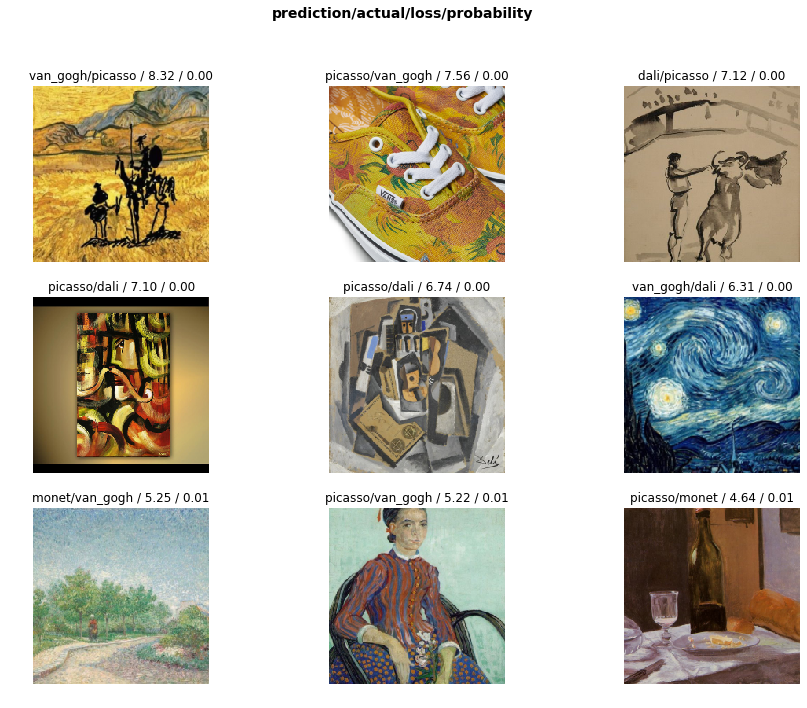

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

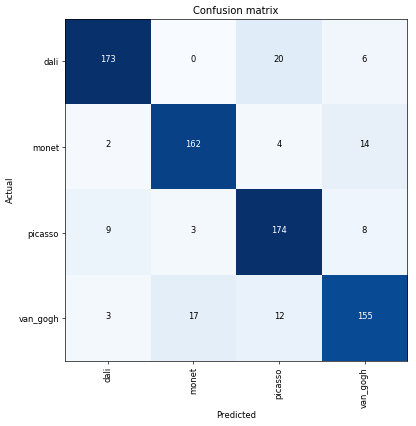

In [17]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('dali', 'picasso', 20),
 ('van_gogh', 'monet', 17),
 ('monet', 'van_gogh', 14),
 ('van_gogh', 'picasso', 12),
 ('picasso', 'dali', 9),
 ('picasso', 'van_gogh', 8),
 ('dali', 'van_gogh', 6),
 ('monet', 'picasso', 4),
 ('picasso', 'monet', 3),
 ('van_gogh', 'dali', 3)]

## Unfreezing, fine-tuning
We retrain all layers, not just the final ones

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.460340,0.513537,0.165354


In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


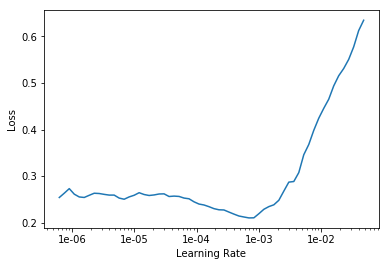

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.239087,0.384843,0.128609
2,0.230865,0.374225,0.115486


## Resnet50 and higher resolution
Our lowest error rate was 0.11 with resnet36. We have a small training dataset (300 for train, 200 for validation)
We try with resnet50 and see if we get better results

In [31]:
bs = 64

In [32]:
data = ImageDataBunch.from_folder(path_img,ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [33]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


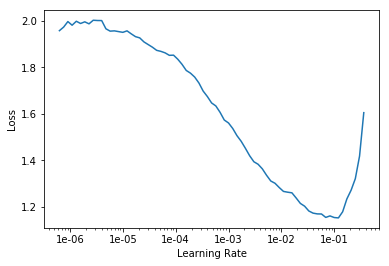

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.866205,0.443116,0.158793
2,0.614215,0.411814,0.141732
3,0.500278,0.364334,0.127297
4,0.410506,0.322778,0.111549
5,0.307687,0.320924,0.098425
6,0.252518,0.314445,0.099738
7,0.207826,0.306832,0.101050
8,0.170340,0.300248,0.101050


In [29]:
learn.save('stage-1-50')

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,error_rate
1,1.356272,0.620198,0.221929
2,0.922329,0.455867,0.150594
3,0.724980,0.431514,0.143989


In [38]:
learn.load('stage-1-50')
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))


epoch,train_loss,valid_loss,error_rate
1,0.156844,0.290161,0.085865
2,0.226286,0.535423,0.147952
3,0.202755,0.409550,0.134742
4,0.150994,0.281851,0.091149
5,0.104001,0.265780,0.080581
6,0.077565,0.259363,0.076618


### Interpret the results

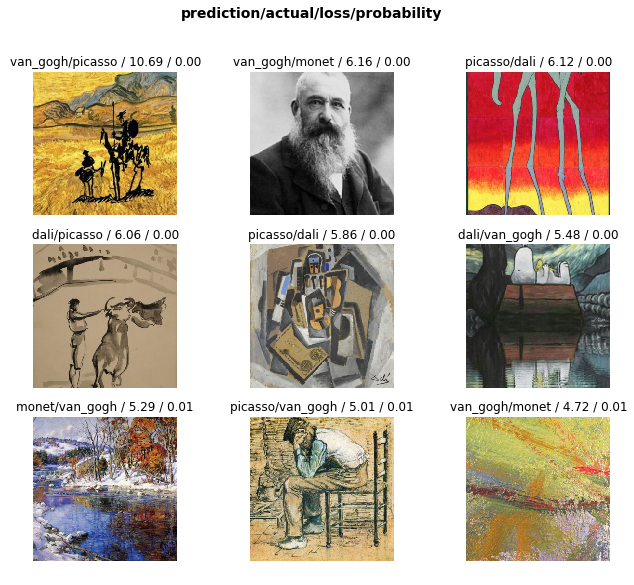

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(11,9))

In [41]:
interp.most_confused(min_val=2)

[('dali', 'picasso', 12),
 ('monet', 'van_gogh', 9),
 ('picasso', 'dali', 9),
 ('van_gogh', 'picasso', 7),
 ('picasso', 'van_gogh', 6),
 ('van_gogh', 'monet', 6),
 ('dali', 'van_gogh', 3),
 ('monet', 'picasso', 3)]

### Test with other learning rate

In [37]:
learn.load('stage-1-50')
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-2))


epoch,train_loss,valid_loss,error_rate
1,0.526946,2.057111,0.317041
2,0.458797,0.502675,0.151915
3,0.338860,0.325946,0.103038


## Summary
The goal was to classify paintings from Dali, Van Gogh, Monet, and Picasso.
We get the lowest error rate with resnet50, without choosing a learning rate
This the part we are going to see next week to understand better

* **Lowest error rate: 0.076618**
* **resnet50**
* **learn.unfreeze()**
* **learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))**
